In [1]:
import os
import json
import time
import flask
import numpy as np
import pandas
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import keras
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import TensorBoard
#d3.js
#Visualization re file
from flask import Flask, jsonify, render_template, request
import math
from flask_bootstrap import Bootstrap

#from models import model_from_json
#from ipykernel import kernelapp as app
#test vis1
#from IPython.display import SVG
#from keras.utils.visualize_util import model_to_dot
#test vis2
#from keras.utils import plot_model
#from IPython.display import SVG
#from keras.utils.visualize_util import model_to_dot
#import pydot
#test section by Fuming
#import ipytracer
#from IPython.core.display import display
#from IPython.display import HTML
#test section end

os.environ["CUDA_VISIBLE_DEVICES"] = "0" #xi
DATA_PATH = '/Users/xiangfuming/Documents/MU CS/Artificial intelligent 2/Final Project/Data'
PROJECT_PATH = '/Users/xiangfuming/Documents/MU CS/Artificial intelligent 2/Final Project/'

Using TensorFlow backend.


In [2]:
# read the train and test data
# resize the image to 128 by 128
#remote = callbacks.RemoteMonitor(root='http://localhost:9000')

train = pandas.read_csv(DATA_PATH + '/train.csv')
test = pandas.read_csv(DATA_PATH + '/test.csv')

# get the pre-extracted features
feat_train = train.copy()
feat_test = test.copy()
feat_train = feat_train.drop(['id', 'species'], axis=1)
feat_test = feat_test.drop(['id'], axis=1)
feat_train = StandardScaler().fit(feat_train).transform(feat_train)
feat_test = StandardScaler().fit(feat_test).transform(feat_test)

# image_data contains ALL images from the images folder
image_data = {}
for img in os.listdir(DATA_PATH + '/images'):
    resized_img = imresize(imread(DATA_PATH + '/images/' + img), (128,128)).astype(np.float32)
    image_data[img.split(".")[0]] = resized_img

In [3]:
print(train.shape)
print(feat_train.shape)
print(test.shape)
print(feat_test.shape)
print(len(image_data))

(990, 194)
(990, 192)
(594, 193)
(594, 192)
1584


In [4]:
# for key, value in image_data.items() :
#     print (key, value)
#     exit()

(128, 128)


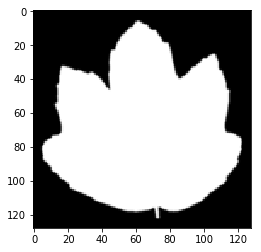

In [5]:
plt.imshow(image_data['1'], cmap='gray')
print (image_data['1'].shape)
plt.show()

In [6]:
# get labels
le = LabelEncoder()
le.fit(train.species)
print(le.classes_)
print(len(le.classes_))

['Acer_Capillipes' 'Acer_Circinatum' 'Acer_Mono' 'Acer_Opalus'
 'Acer_Palmatum' 'Acer_Pictum' 'Acer_Platanoids' 'Acer_Rubrum'
 'Acer_Rufinerve' 'Acer_Saccharinum' 'Alnus_Cordata' 'Alnus_Maximowiczii'
 'Alnus_Rubra' 'Alnus_Sieboldiana' 'Alnus_Viridis' 'Arundinaria_Simonii'
 'Betula_Austrosinensis' 'Betula_Pendula' 'Callicarpa_Bodinieri'
 'Castanea_Sativa' 'Celtis_Koraiensis' 'Cercis_Siliquastrum'
 'Cornus_Chinensis' 'Cornus_Controversa' 'Cornus_Macrophylla'
 'Cotinus_Coggygria' 'Crataegus_Monogyna' 'Cytisus_Battandieri'
 'Eucalyptus_Glaucescens' 'Eucalyptus_Neglecta' 'Eucalyptus_Urnigera'
 'Fagus_Sylvatica' 'Ginkgo_Biloba' 'Ilex_Aquifolium' 'Ilex_Cornuta'
 'Liquidambar_Styraciflua' 'Liriodendron_Tulipifera'
 'Lithocarpus_Cleistocarpus' 'Lithocarpus_Edulis' 'Magnolia_Heptapeta'
 'Magnolia_Salicifolia' 'Morus_Nigra' 'Olea_Europaea' 'Phildelphus'
 'Populus_Adenopoda' 'Populus_Grandidentata' 'Populus_Nigra' 'Prunus_Avium'
 'Prunus_X_Shmittii' 'Pterocarya_Stenoptera' 'Quercus_Afares'
 'Querc

In [7]:
train_labels = le.transform(train.species)
print(train_labels)
print(len(train_labels))

[ 3 49 65 94 84 40 54 78 53 89 98 16 74 50 58 31 43  4 75 44 83 84 13 66 15
  6 73 22 73 31 36 27 94 88 12 28 21 25 20 60 84 65 69 58 23 76 18 52 54  9
 48 47 64 81 83 36 58 21 81 20 62 88 34 92 79 82 20 32  4 84 36 35 72 60 71
 72 52 50 54 11 51 18 47  5  8 37 97 20 33  1 59  1 56  1  9 57 20 79 29 16
 32 54 93 10 46 59 84 76 15 10 15  0 69  4 51 51 94 36 39 62  2 24 26 35 25
 87  0 55 34 38  1 45  7 93 56 38 21 51 75 81 74 33 20 37  9 40 60 31 83 50
 71 67 30 66  1 43 61 23 65 84 87 46 57 16  2 28 12 96 44 76 29 75 41 87 67
 61 30  5 12 62  3 83 81  6 85  4 37 57 84 39 71 61  6 76 14 31 98 40 17 51
 16 42 63 86 37 69 86 71 80 78 14 35 25  5 39  8  9 26 44 60 13 14 77 13 80
 87 18 60 78 92 51 45 78 41 51 30 14 35 46 21  8  6 92 38 40 15 32 17 93 71
 92 27 78 15 19 60 21 38 36 49 74 67 95 31 82 45 16 83 63 80 42 22 74 53 15
 44 47 57 94 76 17 32 24 15 93 24 80 59 46 12 51 77 79 70 69 16  2 63 83 55
 12 53  1 67  0  2 36 42 10  9 52 59  6 22 86 31 51 37 43 75 90 24 86 96 45
 32 98 36 66

In [8]:
# separate train and test from image_data
image_train = np.array([image_data[str(idx)] for idx in train.id])
image_test = np.array([image_data[str(idx)] for idx in test.id])
print (image_train.shape)
image_train = np.expand_dims(image_train, axis=4)
image_test = np.expand_dims(image_test, axis=4)
print(image_train.shape)
print(image_test.shape)

(990, 128, 128)
(990, 128, 128, 1)
(594, 128, 128, 1)


In [9]:
# # randomly split original train into train and validation
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
# for train_index, val_index in sss.split(image_train, train_labels):
#     image_train_X, image_val_X = image_train[train_index], image_train[val_index]
#     image_train_Y, image_val_Y = train_labels[train_index], train_labels[val_index]
#     print(image_train_X.shape)
#     print(image_train_Y.shape)
#     print(image_val_X.shape)
#     print(image_val_Y.shape)
#     print("TRAIN:", train_index)
#     print("VAL:", val_index)
#     plt.imshow(image_train_X[0, :, :, 0], cmap='gray')
#     plt.show()
#     print(train_index[0])
#     print(image_train_Y[0])
#     print(le.inverse_transform([image_train_Y[0]]))

In [10]:
# Convert class vectors to binary class matrices (one-hot encoding)
num_classes = 99
train_labels_cat = keras.utils.to_categorical(train_labels, num_classes)
print(image_train.shape)
print(train_labels_cat.shape)
print(train_labels_cat[0,:])

(990, 128, 128, 1)
(990, 99)
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [11]:
# Keras expects batches of images, so we have to add a dimension to trick it into being nice
#leaf_batch = np.expand_dims(image_train['1'],axis=0)

#def visualize_leaf(model, im):
    # Keras expects batches of images, so we have to add a dimension to trick it into being nice
#    conv_leaf = model.predict(leaf_batch)
#    conv_leaf = np.squeeze(conv_leaf, axis=0)
#    print conv_leaf.shape
#    plt.imshow(conv_leaf)

In [12]:
# build keras model for Images only
# model 1: following the CIFAR 10 example from Keras

img_model = Sequential()

layer0 = Conv2D(32, (3, 3), padding='same', input_shape=image_train.shape[1:])
layer1 = Activation('relu')
layer2 = Conv2D(32, (3, 3))
layer3 = Activation('relu')
layer4 = MaxPooling2D(pool_size=(2, 2))
layer5 = Dropout(0.25)

layer6 = Conv2D(64, (3, 3), padding='same')
layer7 = Activation('relu')
layer8 = Conv2D(64, (3, 3))
layer9 = Activation('relu')
layer10 = MaxPooling2D(pool_size=(2, 2))
layer11 = Dropout(0.25)

layer12 = Flatten()
layer13 = Dense(512)
layer14 = Activation('relu')
layer15 = Dropout(0.5)
layer16 = Dense(num_classes)
layer17 = Activation('softmax')

img_model.add(layer0)
img_model.add(layer1)
img_model.add(layer2)
img_model.add(layer3)
img_model.add(layer4)
img_model.add(layer5)
img_model.add(layer6)
img_model.add(layer7)
img_model.add(layer8)
img_model.add(layer9)
img_model.add(layer10)
img_model.add(layer11)
img_model.add(layer12)
img_model.add(layer13)
img_model.add(layer14)
img_model.add(layer15)
img_model.add(layer16)
img_model.add(layer17)

#img_model.add(Conv2D(32, (3, 3), padding='same', input_shape=image_train.shape[1:]))  
#visualize_leaf(img_model, image_data['1'])
#img_model.add(Activation('relu'))
#img_model.add(Conv2D(32, (3, 3)))
#img_model.add(Activation('relu'))
#img_model.add(MaxPooling2D(pool_size=(2, 2)))
#img_model.add(Dropout(0.25))

#img_model.add(Conv2D(64, (3, 3), padding='same'))
#img_model.add(Activation('relu'))
#img_model.add(Conv2D(64, (3, 3)))
#img_model.add(Activation('relu'))
#img_model.add(MaxPooling2D(pool_size=(2, 2)))
#img_model.add(Dropout(0.25))

#img_model.add(Flatten())
#img_model.add(Dense(512))
#img_model.add(Activation('relu'))
#img_model.add(Dropout(0.5))
#img_model.add(Dense(num_classes))
#img_model.add(Activation('softmax'))

json_image_model = img_model.to_json()

# Let's train the model using RMSprop
img_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print (layer0.get_weights())
#print (img_model.get_weights())

[array([[[[-0.10905117, -0.13017507, -0.0287284 ,  0.13612242, -0.03460477,
           0.11239462, -0.0647191 , -0.00923552,  0.05111302, -0.05617552,
          -0.01668921, -0.0706625 ,  0.13035892, -0.05773509,  0.08540308,
          -0.03194381,  0.02070066,  0.00698337,  0.13986109,  0.11414294,
          -0.09253918,  0.00909665,  0.0639115 ,  0.03125897,  0.07698618,
           0.11379384, -0.12968385, -0.01160617,  0.08289044,  0.12705357,
          -0.08961135,  0.06631662]],

        [[ 0.08887163,  0.13937081, -0.06289216,  0.07820378, -0.0063453 ,
           0.01531836,  0.09174666, -0.00490224,  0.01703429, -0.01925956,
          -0.07812513,  0.08926834,  0.0639948 , -0.08190557, -0.05566213,
          -0.06952002,  0.11476676, -0.05609927,  0.1362844 , -0.10475689,
           0.02302855,  0.06208822, -0.046049  ,  0.02965096, -0.13553466,
          -0.12635323,  0.128157  , -0.02531205, -0.02506762,  0.0763713 ,
          -0.10805009,  0.02670909]],

        [[ 0.00961933

In [13]:
# output the model summary
img_model.count_params()
img_model.summary()

#img_model.fit(image_train, train_labels_cat,
#                            batch_size=16,
#                            epochs=10,
#                            validation_data=(image_train, train_labels_cat),
#                            validation_split=0.1,
#                            shuffle=True,
 #                           callbacks=[remote])
#img_model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=10, validation_data=(X_test, Y_test), callbacks=[remote])
#plot_model(img_model, to_file='model.png', show_shapes='True')
#SVG(model_to_dot(img_model).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 64)        18496     
__________

In [15]:
#build html page to show real time model

app = Flask(__name__)
Bootstrap(app)

#@app.route('/_send_json')
#def sendjson():
#    return json_image_model

@app.route('/')
def index():
    return render_template('image_model.html', data=json_image_model)
    #return layer0.get_weights()[0].toString()
if __name__ == '__main__':
    app.run()

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [25/Apr/2017 11:05:35] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2017 11:05:35] "GET /static/js/bootstrap.min.js HTTP/1.1" 304 -
127.0.0.1 - - [25/Apr/2017 11:05:35] "GET /static/js/echarts.js HTTP/1.1" 304 -
127.0.0.1 - - [25/Apr/2017 11:05:35] "GET /static/js/jquery.min.js HTTP/1.1" 304 -
127.0.0.1 - - [25/Apr/2017 11:05:35] "GET /static/css/bootstrap.min.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Apr/2017 11:05:35] "GET /static/fonts/glyphicons-halflings-regular.woff2 HTTP/1.1" 304 -
127.0.0.1 - - [25/Apr/2017 11:06:09] "GET /static/img/leaf.jpg HTTP/1.1" 304 -


In [65]:
#实时
#tbCallBack = keras.callbacks.TensorBoard(log_dir='./1', histogram_freq=0, write_graph=True, write_images=True)

#img_model.fit(image_train, train_labels_cat,
#                            batch_size=16,
#                            epochs=10,
#                            validation_split=0.1,
#                            shuffle=True,
#                            callbacks=[tbCallBack])

In [66]:
#tbCallBack.set_model(img_model)

In [67]:
img_history = img_model.fit(image_train, train_labels_cat,
                            batch_size=16,
                            epochs=10,
                            validation_split=0.1,
                            shuffle=True)

Train on 891 samples, validate on 99 samples
Epoch 1/10
891/891 [==============================] - 77s - loss: 16.0021 - acc: 0.0067 - val_loss: 15.6297 - val_acc: 0.0303

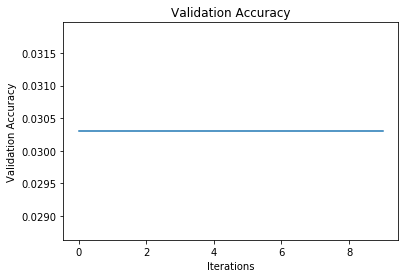

[array([[[[-0.03055394, -0.04753075,  0.07810089, -0.12793316,  0.06074324,
          -0.06319616,  0.13772276, -0.06123362, -0.06297427, -0.03251873,
          -0.12974861,  0.01921789, -0.06600744,  0.03813012, -0.00832259,
          -0.05112595,  0.05856562, -0.04025093, -0.04910075, -0.09264669,
           0.03518656,  0.11918813,  0.01231204,  0.00346936,  0.08282252,
           0.03784493, -0.12231468, -0.07950731, -0.00430817,  0.07884601,
          -0.09363644,  0.11087367]],

        [[ 0.0075953 ,  0.10795851,  0.01229026, -0.12119361, -0.06209092,
          -0.0043052 , -0.03339518, -0.1223591 , -0.02815442,  0.07655898,
          -0.13692047, -0.05649646, -0.06568938,  0.04758539, -0.0078322 ,
           0.14214629, -0.05887421, -0.08871269, -0.1049321 , -0.11775789,
          -0.07726728,  0.05901544, -0.00162464,  0.07334039, -0.10701668,
          -0.11608687,  0.13785097, -0.1114482 , -0.11652844,  0.11475828,
           0.03432265,  0.11863819]],

        [[-0.12168252

In [68]:
plt.plot(img_history.history['val_acc'])
plt.xlabel('Iterations')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')
plt.show()
img_model.save_weights('img_model_weight.h5');
#plot_model(img_model, to_file='model.png')


In [78]:
#test weight for first Conv2D layer
print (layer0.get_weights()[0][0][0][0][0])
print (layer0.get_weights()[0][0][1][0][0])
print (layer0.get_weights()[0][0][2][0][0])
print (layer0.get_weights()[0][1][0][0][0])
print (layer0.get_weights()[0][1][1][0][0])
print (layer0.get_weights()[0][1][2][0][0])
print (layer0.get_weights()[0][2][0][0][0])
print (layer0.get_weights()[0][2][1][0][0])
print (layer0.get_weights()[0][2][2][0][0])

-0.0305539
0.0075953
-0.121683
-0.0647699
0.0338868
-0.0925213
-0.0219671
-0.0631593
-0.0846476


In [ ]:
#build html page to show real time model

app = Flask(__name__)
Bootstrap(app)

#@app.route('/_send_json')
#def sendjson():
#    return json_image_model

@app.route('/')
def index():
    #return render_template('image_model.html', data=json_image_model)
    return layer0.get_weights()[0].toString()
if __name__ == '__main__':
    app.run()

### Using Features Only

In [188]:
# build keras model for Features only
feat_model = Sequential()
feat_model.add(Dense(512, input_dim=192, kernel_initializer='uniform', activation='relu'))
feat_model.add(Dropout(0.3))
feat_model.add(Dense(256, activation='sigmoid'))
feat_model.add(Dropout(0.3))
feat_model.add(Dense(99, activation='softmax'))

json_feat_model = feat_model.to_json()
feat_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=["accuracy"])

In [190]:
#build html page to show real time model

app = Flask(__name__)
Bootstrap(app)

#@app.route('/_send_json')
#def sendjson():
#    return json_image_model

@app.route('/')
def index():
    return render_template('image_model.html', data=json_feat_model)
    #return json_image_model
if __name__ == '__main__':
    app.run()

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [23/Apr/2017 23:24:02] "GET / HTTP/1.1" 200 -


In [18]:
# output the model summary
feat_model.count_params()
feat_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               98816     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 99)                25443     
Total params: 255,587
Trainable params: 255,587
Non-trainable params: 0
_________________________________________________________________


In [19]:
feat_history = feat_model.fit(feat_train, train_labels_cat,
                              batch_size=16,
                              epochs=50,
                              validation_split=0.1,
                              shuffle=True)

Train on 891 samples, validate on 99 samples
Epoch 1/50
891/891 [==============================] - 0s - loss: 4.2385 - acc: 0.1257 - val_loss: 3.5214 - val_acc: 0.4141
Epoch 2/50
891/891 [==============================] - 0s - loss: 2.9184 - acc: 0.4658 - val_loss: 2.4385 - val_acc: 0.7172
Epoch 3/50
891/891 [==============================] - 0s - loss: 1.8962 - acc: 0.7149 - val_loss: 1.5068 - val_acc: 0.8384

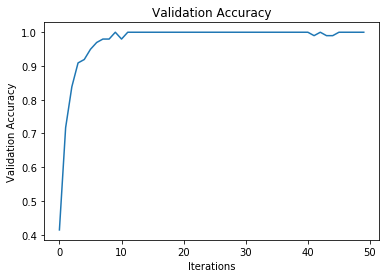

In [20]:
plt.plot(feat_history.history['val_acc'])
plt.xlabel('Iterations')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')
plt.show()

In [22]:
# do prediction
pred = feat_model.predict_proba(feat_test)
columns = sorted(train.species.unique())
pred = pandas.DataFrame(pred, index=test.id, columns=columns)
output = open('prediction_fully_connected.csv','w')
output.write(pred.to_csv())
output.close()

 32/594 [>.............................] - ETA: 0s